<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_multiple_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

In [1]:
import sys


sys.path.append("..")

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.model.models import DRLAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot

from pprint import pprint

/opt/conda/lib/python3.6/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [4]:
# from config.py start_date is a string
config.START_DATE = "2012-01-01"

In [5]:
# from config.py end_date is a string
config.END_DATE
print(f"start: {config.START_DATE}, end: {config.END_DATE}")

start: 2012-01-01, end: 2020-12-01


In [6]:
pprint(config.DOW_30_TICKER)

['AAPL',
 'MSFT',
 'JPM',
 'V',
 'RTX',
 'PG',
 'GS',
 'NKE',
 'DIS',
 'AXP',
 'HD',
 'INTC',
 'WMT',
 'IBM',
 'MRK',
 'UNH',
 'KO',
 'CAT',
 'TRV',
 'JNJ',
 'CVX',
 'MCD',
 'VZ',
 'CSCO',
 'XOM',
 'BA',
 'MMM',
 'PFE',
 'WBA',
 'DD']


In [7]:
df = YahooDownloader(start_date = config.START_DATE,
                     end_date = config.END_DATE,
                     ticker_list = config.DOW_30_TICKER[:5]).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (11215, 7)


In [8]:
df.shape

(11215, 7)

In [9]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic
0,2012-01-03,14.621428,14.732142,14.607142,12.669562,302220800,AAPL
1,2012-01-03,34.060001,35.189999,34.009998,26.867037,44102800,JPM
2,2012-01-03,26.549999,26.959999,26.389999,21.849474,64731500,MSFT
3,2012-01-03,47.142857,47.602264,46.840782,37.876240,7746600,RTX
4,2012-01-03,25.850000,25.850000,25.462500,24.103426,16829200,V


In [10]:
fe = FeatureEngineer(use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)


processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [11]:
processed.sort_values(['date','tic'],ignore_index=True).head(10)

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2012-01-03,14.621428,14.732142,14.607142,12.669562,302220800,AAPL,0.000000,100.0,66.666667,100.0,0.0
1,2012-01-03,34.060001,35.189999,34.009998,26.867037,44102800,JPM,0.000000,100.0,66.666667,100.0,0.0
2,2012-01-03,26.549999,26.959999,26.389999,21.849474,64731500,MSFT,0.000000,100.0,66.666667,100.0,0.0
3,2012-01-03,47.142857,47.602264,46.840782,37.876240,7746600,RTX,0.000000,100.0,66.666667,100.0,0.0
4,2012-01-03,25.850000,25.850000,25.462500,24.103426,16829200,V,0.000000,100.0,66.666667,100.0,0.0
5,2012-01-04,14.642858,14.810000,14.617143,12.737655,260022000,AAPL,0.001528,100.0,66.666667,100.0,0.0
6,2012-01-04,34.439999,35.150002,34.330002,27.037233,36571200,JPM,0.003819,100.0,66.666667,100.0,0.0
7,2012-01-04,26.820000,27.469999,26.780001,22.363672,80516100,MSFT,0.011537,100.0,66.666667,100.0,0.0
8,2012-01-04,46.746380,47.356827,46.626808,38.074100,9805200,RTX,0.004439,100.0,-66.666667,100.0,0.0
9,2012-01-04,25.422501,25.615000,25.000000,23.672802,16522000,V,-0.009661,0.0,-66.666667,100.0,0.0


In [12]:
train = data_split(processed, '2009-01-01','2019-01-01')
trade = data_split(processed, '2019-01-01','2020-12-01')
print(len(train))
print(len(trade))


8800
2415


In [13]:
train.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2012-01-03,14.621428,14.732142,14.607142,12.669562,302220800,AAPL,0.0,100.0,66.666667,100.0,0.0
0,2012-01-03,34.060001,35.189999,34.009998,26.867037,44102800,JPM,0.0,100.0,66.666667,100.0,0.0
0,2012-01-03,26.549999,26.959999,26.389999,21.849474,64731500,MSFT,0.0,100.0,66.666667,100.0,0.0
0,2012-01-03,47.142857,47.602264,46.840782,37.876240,7746600,RTX,0.0,100.0,66.666667,100.0,0.0
0,2012-01-03,25.850000,25.850000,25.462500,24.103426,16829200,V,0.0,100.0,66.666667,100.0,0.0


In [14]:
trade.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2019-01-02,38.722500,39.712502,38.557499,38.562561,148158800,AAPL,-2.019903,37.867349,-91.567852,42.250808,5.699491
0,2019-01-02,95.949997,99.779999,95.940002,92.264069,15670900,JPM,-2.581199,43.028849,-61.153896,16.147418,5.699491
0,2019-01-02,99.550003,101.750000,98.940002,98.602066,35329300,MSFT,-1.908755,45.769243,-81.402190,21.611852,5.699491
0,2019-01-02,66.179985,68.187538,65.601006,64.796608,9361700,RTX,-2.988610,36.800140,-109.397938,44.007805,5.699491
0,2019-01-02,130.000000,133.740005,129.600006,131.264542,8788000,V,-2.114526,47.278524,-46.722946,11.039625,5.699491


In [15]:
from finrl.env.env_stocktrading import StockTradingEnv

In [18]:

d_i_c= ['open', 'close', 'high', 'low', 'volume', 'macd', 'rsi_30', 'cci_30']

e_train_gym = StockTradingEnv(df = train, 
                              print_verbosity = 500, out_of_cash_penalty = -1e6,
                              daily_information_cols = ['open', 'close', 'high', 'low', 'volume', 'macd', 'rsi_30', 'cci_30'])



In [21]:


env_train, _ = e_train_gym.get_sb_env()
da = DRLAgent(env = env_train)

PPO_PARAMS = {
    "n_steps": 100,
    "ent_coef": 0.01,
    "learning_rate": 0.003,
    "batch_size": 512,
    "n_epochs": 10
}

SAC_PARAMS = {
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "batch_size": 2048,
    "ent_coef": "auto_0.1",
}

TD3_PARAMS = {
    "batch_size": 250, 
    "buffer_size": 1000000, 
    "learning_rate": 0.001
}

model = da.get_model("ppo", model_kwargs = PPO_PARAMS,verbose = 0)
# model  = da.get_model("td3", model_kwargs = TD3_PARAMS)
# model  = da.get_model("sac", model_kwargs = SAC_PARAMS)

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
reset called
{'n_steps': 100, 'ent_coef': 0.01, 'learning_rate': 0.003, 'batch_size': 512, 'n_epochs': 10}


In [22]:
# trained = model.learn(.train_model(model, 'sac_again', total_timesteps = 200000)
trained = model.learn(total_timesteps=2000000, 
                      tb_log_name='td3_betterprint', 
                      log_interval = 1, 
                      n_eval_episodes = 15)

reset called
 date index: 499 of 1760
assets: 1006194.49, cash proportion: 96.54%
 date index: 999 of 1760
assets: 1011142.58, cash proportion: 92.89%
 date index: 1499 of 1760
assets: 1069198.42, cash proportion: 74.69%
end of dates! end assets: 1022661.91 at date 2018-12-31 cumul reward : 4.53
reset called
 date index: 499 of 1760
assets: 1060503.61, cash proportion: 77.20%
 date index: 999 of 1760
assets: 1112914.01, cash proportion: 60.46%
 date index: 1499 of 1760
assets: 1333683.78, cash proportion: 45.36%
end of dates! end assets: 1256468.48 at date 2018-12-31 cumul reward : 51.29
reset called
 date index: 499 of 1760
assets: 1090320.97, cash proportion: 68.78%
 date index: 999 of 1760
assets: 1183992.23, cash proportion: 41.09%
 date index: 1499 of 1760
assets: 1622025.77, cash proportion: 17.40%
end of dates! end assets: 1549589.21 at date 2018-12-31 cumul reward : 109.92
reset called
 date index: 499 of 1760
assets: 1081565.16, cash proportion: 70.03%
 date index: 999 of 1760

AssertionError: 

In [23]:
model.save("ppo_quicksave.model")

In [ ]:



e_trade_gym = StockTradingEnv(df = trade, daily_information_cols = d_i_c)
env_trade, obs_trade = e_trade_gym.get_sb_env()
df_account_value, df_actions = DRLAgent.DRL_prediction(model=model,
                        test_data = trade,
                        test_env = env_trade,
                        test_obs = obs_trade)

In [70]:
data_turbulence = processed[(processed.date<'2019-01-01') & (processed.date>='2009-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

In [71]:
insample_turbulence.turbulence.describe()

count    1760.000000
mean       33.195118
std        36.829039
min         0.000000
25%        13.397484
50%        24.521196
75%        39.585418
max       332.062852
Name: turbulence, dtype: float64

In [72]:
turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)
print(f"Turb threshold {turbulence_threshold:0.2f}")

Turb threshold 332.06


### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [73]:
df_account_value['date'] = df_account_value.dates
df_account_value.head()




,cash,asset_value,total_assets,dates,date
0,1000000.000000,0.000000,1.000000e+06,2019-01-02,2019-01-02
1,1000000.000000,0.000000,1.000000e+06,2019-01-03,2019-01-03
2,984173.023680,15328.003626,9.995010e+05,2019-01-04,2019-01-04
3,974743.530328,25698.059413,1.000442e+06,2019-01-07,2019-01-07
4,954847.540906,45696.521702,1.000544e+06,2019-01-08,2019-01-08


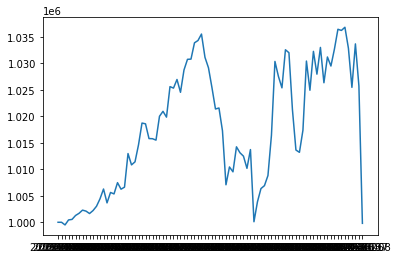

In [74]:
# df_account_value.head()
%matplotlib inline

plt.plot(df_account_value.date, df_account_value.total_assets)

In [75]:
df_actions

,dates,actions
0,2019-01-02,"[-1.4113903, 10.0, 10.0, -10.0, -10.0, -10.0, ..."
1,2019-01-03,"[10.0, 10.0, 10.0, -10.0, 10.0, -10.0, 10.0, 1..."
2,2019-01-04,"[10.0, 10.0, 10.0, 10.0, -10.0, -10.0, 10.0, 1..."
3,2019-01-07,"[10.0, 10.0, 10.0, 10.0, 10.0, -10.0, 10.0, 10..."
4,2019-01-08,"[10.0, 10.0, 10.0, -10.0, 8.0036545, -10.0, 10..."
...,...,...
82,2019-05-01,"[10.0, 10.0, 10.0, 10.0, -10.0, 10.0, 10.0, 10..."
83,2019-05-02,"[10.0, 10.0, 10.0, 10.0, -10.0, -10.0, 10.0, -..."
84,2019-05-03,"[10.0, 10.0, 10.0, -10.0, -10.0, -10.0, -10.0,..."
85,2019-05-06,"[10.0, 10.0, 10.0, 10.0, -10.0, -10.0, 10.0, -..."


In [76]:
df_account_value.shape

(88, 5)

In [77]:
df_account_value.head()

,cash,asset_value,total_assets,dates,date
0,1000000.000000,0.000000,1.000000e+06,2019-01-02,2019-01-02
1,1000000.000000,0.000000,1.000000e+06,2019-01-03,2019-01-03
2,984173.023680,15328.003626,9.995010e+05,2019-01-04,2019-01-04
3,974743.530328,25698.059413,1.000442e+06,2019-01-07,2019-01-07
4,954847.540906,45696.521702,1.000544e+06,2019-01-08,2019-01-08


In [78]:
import pandas as pd
import numpy as np

from pyfolio import timeseries
import pyfolio
import matplotlib.pyplot as plt

from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.config import config


def BackTestStats(account_value, value_col_name = 'account_value'):
    df = account_value.copy()
    df = get_daily_return(df, value_col_name = value_col_name)
    DRL_strat = backtest_strat(df)
    perf_func = timeseries.perf_stats
    perf_stats_all = perf_func(
        returns=DRL_strat,
        factor_returns=DRL_strat,
        positions=None,
        transactions=None,
        turnover_denom="AGB",
    )
    print(perf_stats_all)
    return perf_stats_all


def BaselineStats(
    baseline_ticker="^DJI",
    baseline_start=config.START_TRADE_DATE,
    baseline_end=config.END_DATE,
):

    dji, dow_strat = baseline_strat(
        ticker=baseline_ticker, start=baseline_start, end=baseline_end
    )
    perf_func = timeseries.perf_stats
    perf_stats_all = perf_func(
        returns=dow_strat,
        factor_returns=dow_strat,
        positions=None,
        transactions=None,
        turnover_denom="AGB",
    )
    print(perf_stats_all)
    return perf_stats_all


def BackTestPlot(
    account_value,
    baseline_start=config.START_TRADE_DATE,
    baseline_end=config.END_DATE,
    baseline_ticker="^DJI",value_col_name  ='account_value'
):

    df = account_value.copy()
    df = get_daily_return(df, value_col_name = value_col_name)

    dji, dow_strat = baseline_strat(
        ticker=baseline_ticker, start=baseline_start, end=baseline_end
    )
    df["date"] = dji["date"]
    df = df.dropna()

    DRL_strat = backtest_strat(df)

    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(
            returns=DRL_strat, benchmark_rets=dow_strat, set_context=False
        )


def backtest_strat(df):
    strategy_ret = df.copy()
    strategy_ret["date"] = pd.to_datetime(strategy_ret["date"])
    strategy_ret.set_index("date", drop=False, inplace=True)
    strategy_ret.index = strategy_ret.index.tz_localize("UTC")
    del strategy_ret["date"]
    ts = pd.Series(strategy_ret["daily_return"].values, index=strategy_ret.index)
    return ts


def baseline_strat(ticker, start, end):
    dji = YahooDownloader(
        start_date=start, end_date=end, ticker_list=[ticker]
    ).fetch_data()
    dji["daily_return"] = dji["close"].pct_change(1)
    dow_strat = backtest_strat(dji)
    return dji, dow_strat


def get_daily_return(df, value_col_name = 'account_value'):
    df["daily_return"] = df[value_col_name].pct_change(1)
    # df=df.dropna()
    sharpe = (252 ** 0.5) * df["daily_return"].mean() / df["daily_return"].std()

    annual_return = ((df["daily_return"].mean() + 1) ** 252 - 1) * 100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)
    return df


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [79]:
print("==============Get Backtest Results===========")
perf_stats_all = BackTestStats(account_value=df_account_value,value_col_name='total_assets' )
perf_stats_all = pd.DataFrame(perf_stats_all)
# perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
annual return:  0.27947818100353405
sharpe ratio:  0.033866254389707744
Annual return         -0.000574
Cumulative returns    -0.000201
Annual volatility      0.082409
Sharpe ratio           0.033866
Calmar ratio          -0.016068
Stability              0.385819
Max drawdown          -0.035728
Omega ratio            1.006596
Sortino ratio          0.043561
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.933817
Daily value at risk   -0.010372
Alpha                  0.000000
Beta                   1.000000
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
annual return:  0.27947818100353405
sharpe ratio:  0.033866254389707744
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (483, 7)


Start date,2019-01-03
End date,2019-05-08
Total months,4
,Backtest
Annual return,-0.058%
Cumulative returns,-0.02%
Annual volatility,8.241%
Sharpe ratio,0.03
Calmar ratio,-0.02
Stability,0.39
Max drawdown,-3.573%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3.57,2019-05-01,2019-05-08,NaT,NaN
1,3.42,2019-03-04,2019-03-25,2019-04-29,41
2,0.32,2019-02-06,2019-02-12,2019-02-13,6
3,0.26,2019-01-22,2019-01-23,2019-01-28,5
4,0.24,2019-02-21,2019-02-22,2019-02-25,3


/opt/conda/lib/python3.6/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


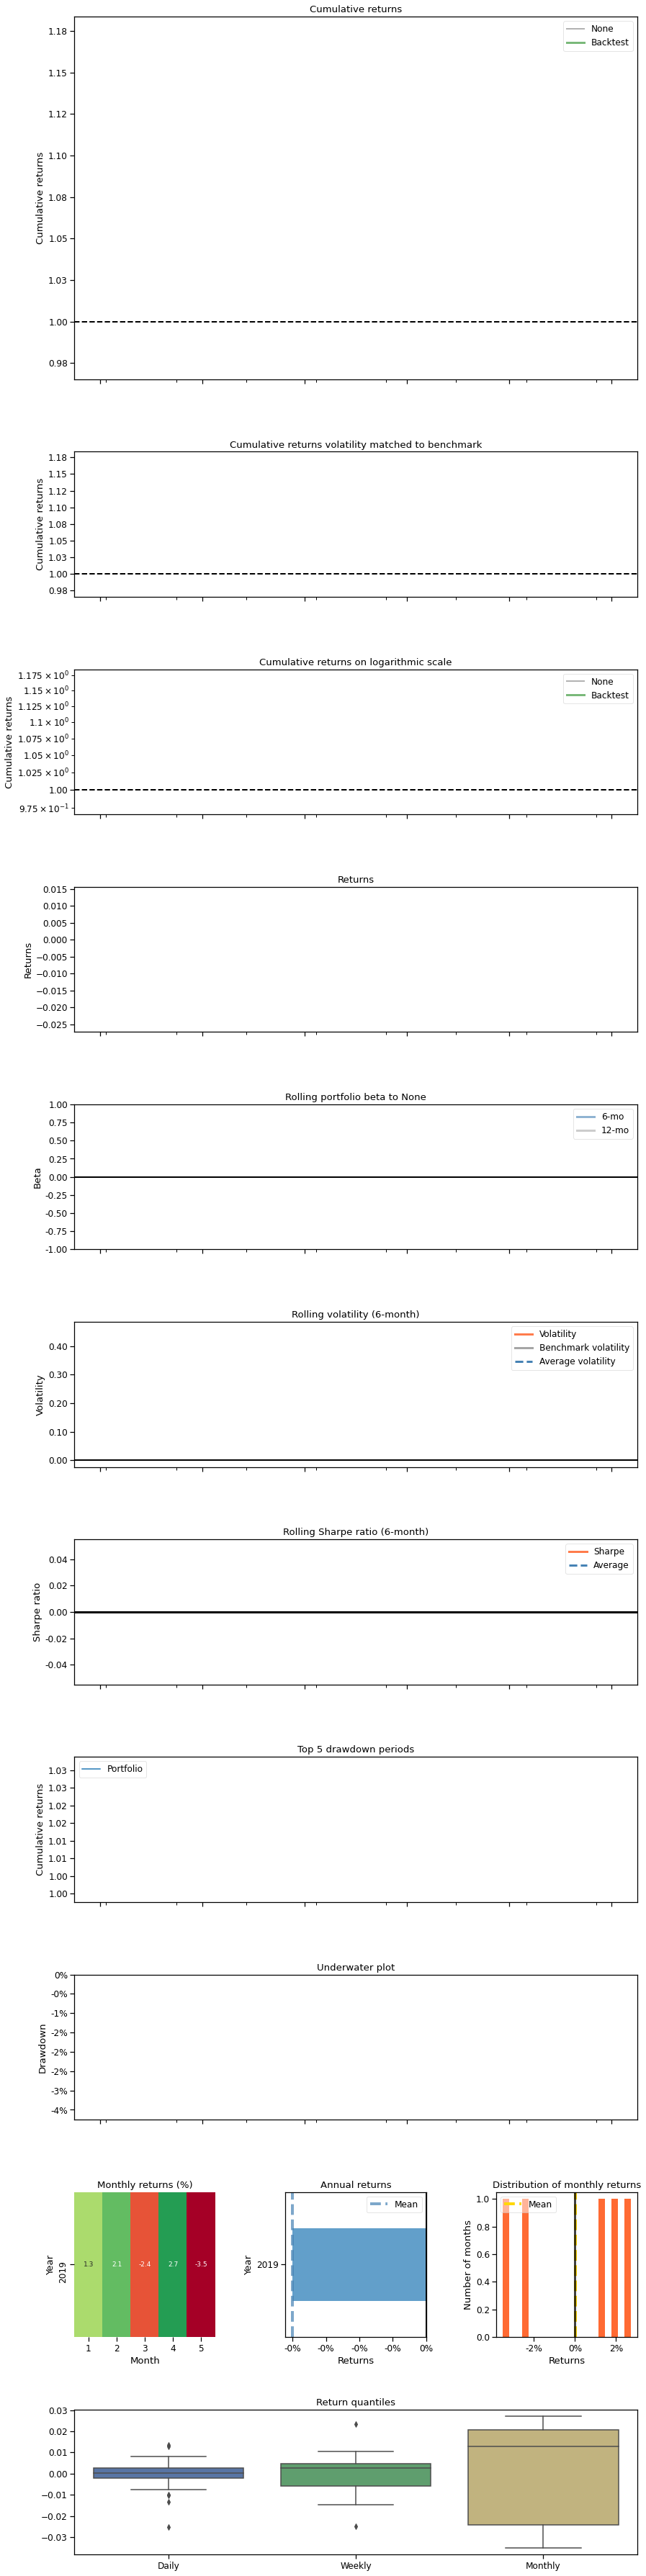

In [80]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
BackTestPlot(df_account_value, 
             baseline_ticker = '^GSPC', 
             baseline_start = '2019-01-01',
             baseline_end = '2020-12-01', value_col_name = 'total_assets')

<a id='6.3'></a>
## 7.3 Baseline Stats

In [81]:
print("==============Get Baseline Stats===========")
baesline_perf_stats=BaselineStats('^DJI',
                                  baseline_start = '2019-01-01',
                                  baseline_end = '2020-12-01')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (483, 7)
Annual return          0.132593
Cumulative returns     0.269525
Annual volatility      0.280347
Sharpe ratio           0.586312
Calmar ratio           0.357526
Stability              0.060828
Max drawdown          -0.370862
Omega ratio            1.137261
Sortino ratio          0.807330
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.844803
Daily value at risk   -0.034668
Alpha                  0.000000
Beta                   1.000000
dtype: float64
